In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


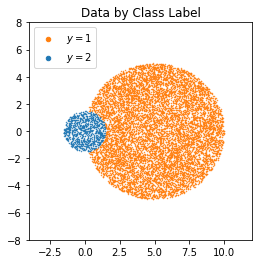

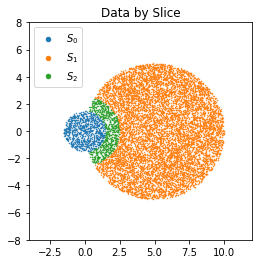

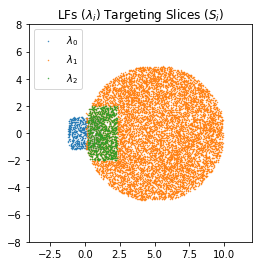

In [2]:
from metal.utils import split_data
from visualization_utils import visualize_data
from data_generators import generate_pacman_data

config = {
    'N': 10000,
    'mus': np.array([[0,  0], [5, 0]]),
    'variances': [1.5, 5],
    'labels': [2, 1],
    'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
}

X, Y, Z, L = generate_pacman_data(config)
Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

visualize_data(X, Y, Z, L)

In [3]:
from metal.analysis import lf_summary
lf_summary(Ls[1], Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,2,0.072686,0.035960,0.035960,186,4,0.978947
1,1,0.951798,0.105203,0.035960,2373,115,0.953778
2,1,0.101760,0.101760,0.032517,161,105,0.605263


In [4]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

# replace GT with weak labels
label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])
Y_train = label_model.predict_proba(Ls[0])
Ys[0] = Y_train

# for testing LFs
X_test = torch.Tensor(Xs[2])
L_test = Ls[2]

## Confirm that we can recover the L matrix

Train slice-aware model with `slice_weight=1.0`. 
Then, try to repredict the `L_test` values using the `L_head`.

In [5]:
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    train_slice_dp,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx

### SliceDP

In [6]:
import torch.nn.functional as F

from metal.contrib.slicing.online_dp import MLPModule
from metal.metrics import accuracy_score


train_kwargs = {
    "disable_prog_bar": True,
    "verbose": True,
    "n_epochs": 20,
    "lr": 0.005,
    "l2": 1e-7,
}
sm_dp_config = {
    'slice_kwargs': {
        'r': 5,
        'slice_weight': 1.0,
        'reweight': True
    },
    'train_kwargs': train_kwargs,
    'input_module_class': MLPModule,
    'input_module_init_kwargs': {
        'input_dim': 2,
        'output_dim': 5,
        'middle_dims': [5],
        'bias': True
    }
}
model = train_slice_dp(sm_dp_config, Ls, Xs, Ys, Zs)
print(model)

# L_preds = model.predict_L_proba(X_test)
L_preds = F.sigmoid(model.forward_L(X_test)).data.cpu().numpy()
preds = (L_preds > 0.5) * 1

L_gt = L_test.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.sum(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))
print ('accuracy over LF2:', accuracy_score(L_gt[:, 2], preds[:, 2]))

/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/Users/bradenjh/repos/metal/metal/contrib/slicing/online_dp.py:159: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  A = F.softmax(self.forward_L(x)).unsqueeze(1)


Slice Heads:
Reweighting: True
L_weights: tensor([[1.],
        [1.],
        [1.]])
Slice Weight: 1.0
Input Network: Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
)
L_head: Linear(in_features=5, out_features=3, bias=False)
Y_head: Linear(in_features=10, out_features=2, bias=True)
Criteria: BCEWithLogitsLoss() SoftCrossEntropyLoss()


/Users/bradenjh/repos/metal/metal/contrib/slicing/online_dp.py:176: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward_Y(x)).data.cpu().numpy()


[1 epo]: train/loss=0.182, valid/accuracy=0.939
[2 epo]: train/loss=0.124, valid/accuracy=0.961
[3 epo]: train/loss=0.118, valid/accuracy=0.962
[4 epo]: train/loss=0.105, valid/accuracy=0.668
[5 epo]: train/loss=0.086, valid/accuracy=0.510
[6 epo]: train/loss=0.074, valid/accuracy=0.505
[7 epo]: train/loss=0.068, valid/accuracy=0.507
[8 epo]: train/loss=0.064, valid/accuracy=0.506
[9 epo]: train/loss=0.062, valid/accuracy=0.482
[10 epo]: train/loss=0.059, valid/accuracy=0.492
[11 epo]: train/loss=0.057, valid/accuracy=0.496
[12 epo]: train/loss=0.056, valid/accuracy=0.508
[13 epo]: train/loss=0.055, valid/accuracy=0.508
[14 epo]: train/loss=0.052, valid/accuracy=0.494
[15 epo]: train/loss=0.044, valid/accuracy=0.508
[16 epo]: train/loss=0.039, valid/accuracy=0.502
[17 epo]: train/loss=0.037, valid/accuracy=0.492
[18 epo]: train/loss=0.037, valid/accuracy=0.497
[19 epo]: train/loss=0.035, valid/accuracy=0.507
[20 epo]: train/loss=0.035, valid/accuracy=0.510
Finished Training
Accuracy: 0

/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### SliceHat

In [40]:
from metal.metrics import accuracy_score

def calc_L_accuracy(model, data_loader):
    X, L, Y = data_loader.dataset.data
    L_probs = model.predict_L_proba(torch.Tensor(X))
    # Convert probs to hard labels
    L_preds = np.round(L_probs)
    L_preds[L_preds == 0] = 2
#     L_preds[L_preds > 0.75] = 1
#     L_preds[L_preds < 0.25] = 2
#     L_preds[L_preds < 1] = 0
    score = accuracy_score(L.reshape(-1,1), L_preds.reshape(-1,1), ignore_in_gold=[0])
    return {"train/L_acc": score} 

In [45]:
end_model_init_kwargs = {
    "layer_out_dims": [2, 5, 5, 2]
}
sm_hat_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 1.0,
        "reweight": True,
        "mask_abstains": True,
    },
    "train_kwargs": {
        "n_epochs": 2,
        "lr": 0.001,
        "l2": 0,
        "log_unit": "batches",
        "log_train_metrics_func": calc_L_accuracy,
        "log_train_metrics": ["train/loss", "train/L_acc"],
        "log_train_every": 5,
        "log_valid_every": 5,
        "checkpoint": True,
        "checkpoint_metric": "train/L_acc"
    }
}

In [46]:
# from metal.contrib.slicing.utils import add_pepper

# Ls[0] = add_pepper(Ls[0], 0.1)
# Ls[0].max(axis=0).todense()

In [47]:
model = train_model(sm_hat_config, Ls, Xs, Ys, Zs, model_key="hat")


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=5, out_features=2, bias=True)
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=3, bias=False)
  (L_criteria): BCEWithLogitsLoss()
)

[5 bat (0.03 epo)]: train/loss=0.275, train/L_acc=0.056, valid/accuracy=0.912
Saving model at iteration 5 with best score 0.056
[10 bat (0.06 epo)]: train/loss=0.263, train/L_acc=0.056, valid/accuracy=0.912
[15 bat (0.09 epo)]: train/loss=0.271, train/L_acc=0.294, valid/accurac

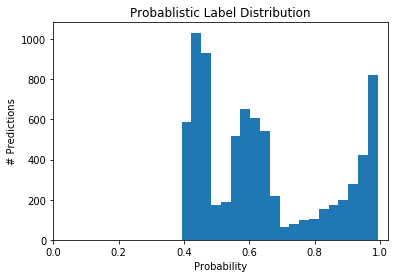

        y=0    y=1    y=2   
 l=0   4888    507    190   
 l=1    10    2247     0    
 l=2     0      0      0    

LF_0: 0.0
LF_1: 0.9031350482315113
LF_2: 0.0


In [49]:
from metal.contrib.visualization.analysis import plot_probabilities_histogram
from metal.analysis import confusion_matrix

# L_probs = torch.sigmoid(abs(model.L_head(model.body(X_test))))
L_probs = model.predict_L_proba(torch.Tensor(Xs[1]))
plot_probabilities_histogram(L_probs.flatten(), title="Probablistic Label Distribution")

# Treat as two-class (1,2)
# L_preds = np.round(L_probs)
# L_preds[L_preds == 0] = 2

# Treat as three-class (0,1,2)
L_preds = L_probs.copy()
L_preds[L_preds > 0.75] = 1
L_preds[L_preds < 0.25] = 2
L_preds[L_preds < 1] = 0

L_gold = np.asarray(Ls[1].todense())

_ = confusion_matrix(L_gold.flatten(), L_preds.flatten(), null_pred=True, null_gold=True)

print()
for j in [0,1,2]:
    score = accuracy_score(L_gold[:,j], L_preds[:,j], ignore_in_gold=[0])
    print(f"LF_{j}: {score}")

In [ ]:
from metal.contrib.visualization.analysis import view_label_matrix

view_label_matrix(Ls[0])